# Coronagraphic Disk Simulation

Quick exercise to simulate what a disk might look like through NIRCam coronagraphy.

In [1]:
# Import the usual libraries
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

We start by importing ``pynrc`` along with the ``obs_hci`` (High Control Imaging) class, which lives in the ``pynrc.obs_nircam`` module.

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

# High-contrast imaging observation class
from pynrc.obs_nircam import obs_hci 

# Disable informational messages and only include warnings and higher
pynrc.setup_logging('WARNING')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


## Define Bandpasses and Stellar Spectrum

Create a dictionary that holds the spectral information to generate model SED

In [3]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

In [4]:
# Various Bandpasses of interest
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')
# and their Vega magnitudes (V, K, W1, W2)
magv, magk, magw1, magw2 = (8.3, 5.7, 4.6, 3.5)

# Science   source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
# Source information
dict_sci = {
    'name': 'MWC 758', 'dist': 140, 'age': 3.5, # units of pc and Myr
    'sptype': 'A5V', 'Teff': None, 'metallicity': None, 'log_g': None,
    'Av': 0, 'mag_val': magv, 'bp': bp_v, # Initial normalization
}

dict_sci['votable_file'] = votdir + dict_sci['name'].replace(' ' ,'') + '.vot'

### Fit SED

In [5]:
# Fit spectrum to SED photometry
# Pass dictionary to source_spectrum to populate args and kwargs
src = source_spectrum(**dict_sci)

# Fit model SED with IR excess component
src.fit_SED(use_err=False, robust=False, wlim=[1,10], IR_excess=True)

# Final source spectrum (pysynphot)
name_sci = dict_sci['name']
spt_sci  = dict_sci['sptype']
dist_sci = dict_sci['dist']
age_sci  = dict_sci['age']
sp_sci   = src.sp_model

SED best-fit params: [7.37158472e-02 3.73028985e+03 1.98836526e+00]


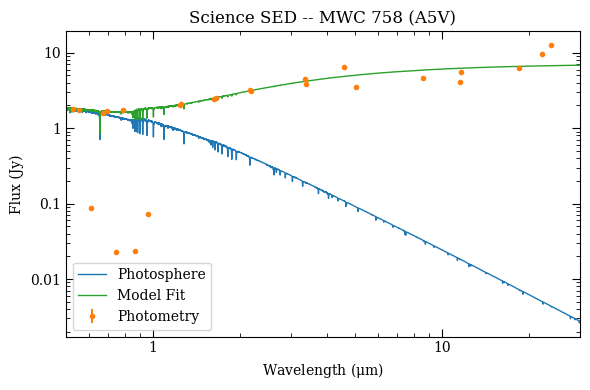

In [6]:
# Plot spectra 
fig, ax = plt.subplots(1,1, figsize=(6,4))

src.plot_SED(ax=ax, xr=[0.5,30])
ax.set_title(f'Science SED -- {name_sci} ({spt_sci})')
ax.set_xlabel(r'Wavelength ($\mathdefault{\mu m}$)')

fig.tight_layout()

## Disk Model

Load in disk model and 

Text(0.5, 1.0, 'Disk Model (example.fits)')

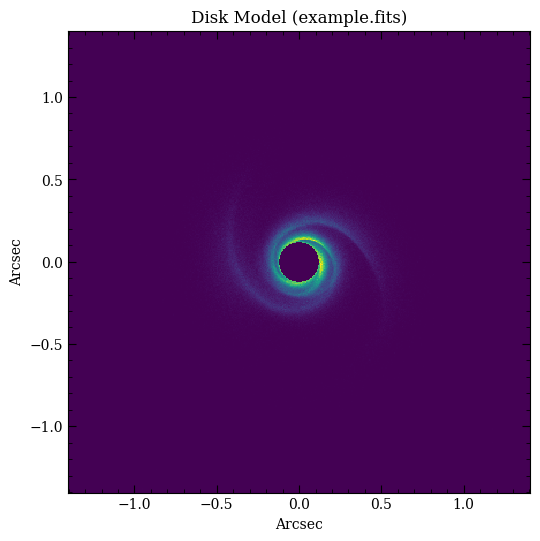

In [7]:
from astropy.io import fits

# Opern file
file_disk = 'example.fits'
hdul = fits.open(file_disk)

# Visualize the model data
data = hdul[0].data

# Pixel scale (Arcsec/pixel)
pixscale = 0.007

# Mask inner region
# WARNING: This is a hack to remove the central star
# and inner disk emission that is unresolved.
rho = nrc_utils.dist_image(data, pixscale=pixscale)
hdul[0].data[rho<0.12] = 0

ny, nx = hdul[0].data.shape
extent = np.array([-nx,nx,-ny,ny]) * pixscale / 2
plt.imshow(hdul[0].data, extent=extent)
plt.xlabel('Arcsec')
plt.ylabel('Arcsec')
plt.title('Disk Model (example.fits)')

In [8]:
# Create a dictionary of information for the model data
# Data is in mJy/arcsec^2
# Units can be any combination of [nJy,uJy,mJy,Jy,MJy]/[sr,arcsec^2,mas^2,pixel]
args_disk = {
    'file': hdul,            # FITS file (name or HDUList)
    'wavelength': 1.6,       # Wavelength of data in microns
    'pixscale': pixscale,    # Arcsec/pixel
    'units': 'mJy/arcsec^2', # Units of data
    'dist': 160,             # Assumed distance in pc
    'cen_star': False,       # Stellar flux included in central pixel?
}

## Create the observation simulation

In [9]:
# Filter, coronagraphic mask, and Lyot stop
filt, mask, pupil = ('F300M', 'MASK335R', 'CIRCLYOT')

# Or you could specify the aperture name directly in place of
# the mask and pupil keywords (e.g., apname='NRCA5_MASK335R')

In [10]:
obs = obs_hci(sp_sci, dist_sci, filter=filt, image_mask=mask, pupil_mask=pupil,
              disk_params=args_disk, autogen_coeffs=False)

# Set number of pixels for PSF simulation and oversampling
obs.fov_pix = 321
obs.oversample = 2

# Generate PSF coefficients
obs.gen_psf_coeff()
# Enable WFE drift
obs.gen_wfedrift_coeff()
# Enable mask-dependent variations
obs.gen_wfemask_coeff()
# Create series of PSFs for disk convolution
obs.gen_disk_psfs()

In [11]:
# if there's a disk input, then we want to remove disk 
# contributions from stellar flux and recompute to make 
# sure total flux counts matches what we computed for 
# sp_sci in previous section for consistent measured photometry
if args_disk is not None:
    star_flux = obs.star_flux(sp=sp_sci) # Pass original input spectrum
    disk_flux = obs.disk_hdulist[0].data.sum()
    sp_sci_new = sp_sci * (1 - disk_flux / star_flux)
    sp_sci_new.name = sp_sci.name

    # Update reference spectrum if necessary
    if obs.sp_ref is obs.sp_sci:
        obs.sp_ref = sp_sci_new

    # Update science spectrum
    obs.sp_sci = sp_sci_new

### Simulated observations of disk

Generate noiseless simulations that show how the disk appears after transmitting through NIRCam's corongraphic optics.

In [12]:
# Generate noiseless disk image
im_disk = obs.gen_disk_image(return_oversample=True)

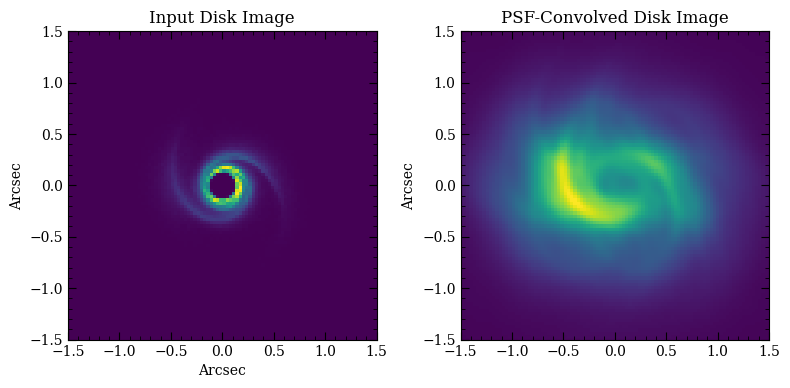

In [13]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

# Plot the input disk image
ax = axes[0]

im = obs.disk_hdulist[0].data
pixscale = obs.disk_hdulist[0].header['PIXELSCL']
rho = nrc_utils.dist_image(im, pixscale=pixscale)
ny, nx = im.shape
extent = np.array([-nx,nx,-ny,ny]) * pixscale / 2
ax.imshow(im, extent=extent)

ax.set_title('Input Disk Image')
ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

# Plot the PSF-convolved disk image
ax = axes[1]

im = im_disk
pixscale = obs.pixelscale / obs.oversample
rho = nrc_utils.dist_image(im, pixscale=pixscale)
ny, nx = im.shape
extent = np.array([-nx,nx,-ny,ny]) * pixscale / 2
ax.imshow(im , extent=extent)

ax.set_title('PSF-Convolved Disk Image')
ax.set_ylabel('Arcsec')

xylim = 1.5
for ax in axes:
    ax.set_xlim([-xylim,xylim])
    ax.set_ylim([-xylim,xylim])

fig.tight_layout()